# Report Document

### Imports

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns

In [5]:
from models import DeGrootThresholdModel
from utils import add_random_edges, assign_edge_weights
from utils.graph_utils import create_sbm_graph, create_random_geometric_graph, create_influencer_graph
from visualization.plot_utils import plot_network, plot_posting_heatmap, plot_sbm_network
from main import run_experiment

### Custom Functions & Constants

In [6]:
ispal_op = [-1, -.5, 0, .5, 1]
ispal_prop = [.1, .2, .29, .22, .19]
abortion_prop = [0.31, 0.34, 0.27, 0.08]
counts = [1, 6, 5, 17, 72, 318, 581]        # influencer counts
thresholds = [.1, .2, .3, .4, .5, .6, .7, .8, .9]

def generate_exponential_edges(n_buckets=7, start=100, r=0.5):
    return [max(1, int(start * r**i)) for i in range(n_buckets)]

def generate_linear_edges(n_buckets=7, start=100, end=1):
    step = (start - end) / (n_buckets - 1)
    return [max(1, int(start - i * step)) for i in range(n_buckets)]

def cyclic_variations(base_vector, delta=0.05, n_variations=None, tol=1e-8):
    """
    Generate structured variations of a probability vector by applying cyclic ±delta shifts.

    Parameters
    ----------
    base_vector : array-like
        A probability vector that sums to 1.
    delta : float
        Amount to perturb each row by (adds to one index, subtracts from another).
    n_variations : int, optional
        Number of variations to return. If None, defaults to len(base_vector).
        If greater than len(base_vector), wraps around cyclically.
    tol : float
        Tolerance for sum check and non-negativity.

    Returns
    -------
    variations : np.ndarray
        Array of shape (n_variations, len(base_vector)) of perturbed probability vectors.
    """
    base = np.array(base_vector, dtype=float)
    d = len(base)

    if not np.allclose(base.sum(), 1.0, atol=tol):
        raise ValueError("Base vector must sum to 1.")

    if n_variations is None:
        n_variations = d

    variations = np.zeros((n_variations, d))

    for i in range(n_variations):
        v = base.copy()
        a = i % d
        b = (i + 1) % d
        v[a] += delta
        v[b] -= delta

        if np.any(v < -tol):  # allow slight negative due to round-off, but not beyond tol
            raise ValueError(f"Delta={delta} is too large at variation {i} (produced negative entry).")

        # Ensure it's clipped to [0, 1] and renormalized if necessary
        v = np.clip(v, 0, 1)
        v /= v.sum()  # rescale to sum to 1
        variations[i] = v

    return variations

## Random SBM vs Geometric

### SBM

Initial opinion distribution:
  Positive opinions: 41.00%
  Negative opinions: 30.00%
  Neutral opinions: 29.00%
  Positive-to-negative ratio: 1.37
  Initial proportion of opinions on positive side: 57.75%


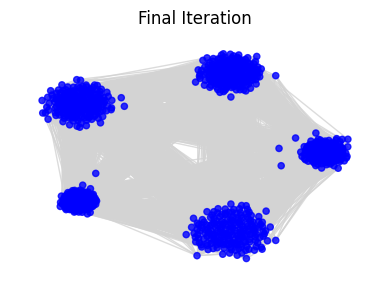

In [ ]:
GSBM = create_sbm_graph(
    sizes=[200, 200, 200, 200, 200],    # sizes of communities
    p_intra=0.1,                        # probability within communities
    p_inter=0.08
)

modelSBM = DeGrootThresholdModel(GSBM, local_agreement_threshold=.6)

modelSBM.initialize_opinions_manual(
    initial_opinions=ispal_op,
    proportions=ispal_prop
)
    

modelSBM.run(10)
plot_sbm_network(GSBM, opinions=modelSBM.opinions, title=f'Final Iteration')

plt.show()

### Geometric

Initial opinion distribution:
  Positive opinions: 41.00%
  Negative opinions: 30.00%
  Neutral opinions: 29.00%
  Positive-to-negative ratio: 1.37
  Initial proportion of opinions on positive side: 57.75%


(<Figure size 400x300 with 2 Axes>,
 <Axes: title={'center': 'Final Iteration'}>)

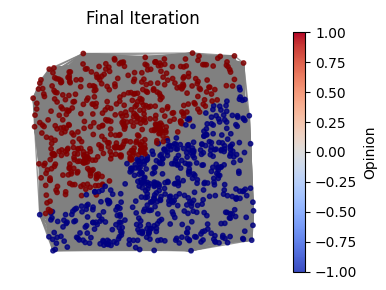

In [42]:
GEO = create_random_geometric_graph(
    n=1000,
    radius=0.6
)

modelGEO = DeGrootThresholdModel(GEO, local_agreement_threshold=.6)
modelGEO.initialize_opinions_manual(
    initial_opinions=ispal_op,
    proportions=ispal_prop
)

modelGEO.run(20)
plot_network(GEO, opinions=modelGEO.opinions, title=f'Final Iteration')


## Clustered SBM

Initial opinion distribution:
  Positive opinions: 41.00%
  Negative opinions: 30.00%
  Neutral opinions: 29.00%
  Positive-to-negative ratio: 1.37
  Initial proportion of opinions on positive side: 57.75%


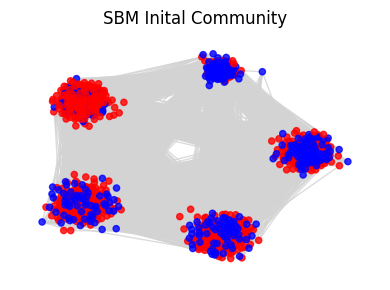

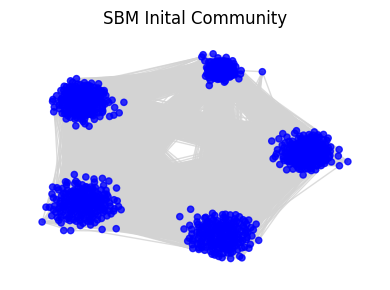

In [21]:
ClustG = create_sbm_graph(
    sizes=[200, 200, 200, 200, 200],  # sizes of communities
    p_intra=0.08,                    # probability within communities
    p_inter=0.01                     # probability between communities
)

modelClust = DeGrootThresholdModel(ClustG, local_agreement_threshold=0.6)

ispal_bias_prop = cyclic_variations(ispal_prop, delta=np.min(ispal_prop))

modelClust.initialize_opinions_manual(
    initial_opinions=ispal_op,
    proportions=ispal_prop, 
    SBM_bias_blocks=ispal_bias_prop
)

plot_sbm_network(ClustG, opinions=modelClust.opinions, title='SBM Inital Community')

modelClust.run(5)

plot_sbm_network(ClustG, opinions=modelClust.opinions, title='SBM Inital Community')





## Influencer Network

### Linear Edges

Initial opinion distribution:
  Positive opinions: 41.00%
  Negative opinions: 30.00%
  Neutral opinions: 29.00%
  Positive-to-negative ratio: 1.37
  Initial proportion of opinions on positive side: 57.75%


(<Figure size 400x300 with 2 Axes>,
 <Axes: title={'center': 'Linear Influencer Graph'}>)

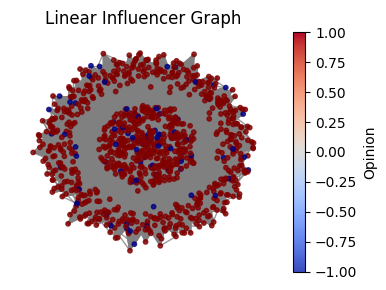

In [24]:
edgesLin = generate_linear_edges(
    n_buckets=len(counts),
    start=750,
    end=1
)

linInfG = create_influencer_graph(
    n_nodes=1000,
    bucket_counts=counts,
    bucket_edges=edgesLin
)

modelLinInf = DeGrootThresholdModel(linInfG, local_agreement_threshold=0.6)
modelLinInf.initialize_opinions_manual(
    initial_opinions=ispal_op,
    proportions=ispal_prop
)

modelLinInf.run(50)
plot_network(linInfG, opinions=modelLinInf.opinions, title='Linear Influencer Graph')

